# MDD with physics-aware factorization-based low-rank regularization

The purpose of this notebook is to demonstrate the importance of the regularization parameter $\lambda$ to the efficiency of our proposed method. It also reproduces the first example in the paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from numpy import inf

In [2]:
import os
import m8r

We first define functions to calcualte the residual and gradient of MDD with the proposed low-rank regularization

In [3]:
def diffQQt(xs, ia, ib):
    xs = xs[0]
    r = ia.dot(xs@xs.T) - ib
    return r

def gradQQt(xs, ir, ia):
    
    xs = xs[0] 
    AhR = ia.T.conj().dot(ir)
    
    dd = (AhR +  AhR.T).dot(xs.conj())   

    return dd

Define the proximal operator of Frobenious norm:

In [4]:
def prox_Fro(v, t, lam):

    nv = norm(v,ord='fro')
    v  = v/(1+lam/t)
    
    nnv = norm(v, ord='fro')
    
    return v, nv**2 * 0.5, nnv**2 * 0.5

Below define the main function to solve the proposed MDD in an alternating style

In [5]:
def ipalm(grads, proxs, tau_guess, inc, diff, argv, ia, ib, xs0): 
    
    nblocks=len(grads)
    # initialize states for inertia
    xs1=list(xs0)
    xs2=list(xs0)
    
    it=0 
    
    lam = argv.lam

    nv, nnv = np.zeros(nblocks), np.zeros(nblocks)

    total_msf_old = inf

    while it < argv.nit: # and err > tol: 
        reg_msf = 0.0    
        #compute inertial coefficients
        if 0 == argv.inertia: 
            inertia = it/(it+3.0)
        else:
            inertia = argv.inertia
        
        for i in range(nblocks):

            yi = xs1[i] + inertia * (xs1[i] - xs0[i])
            zi = xs1[i] + inertia * (xs1[i] - xs0[i])
             
            xs2[i] = zi
    
            # Estimate the resuial and gradient with the current x
            res = diff(xs2, ia, ib)
            data_msf_cur = 0.5*norm(res, ord='fro')**2 
            gg = grads[i](xs2, res, ia)
                        
            ############################################################## 

            cnt = 0
            while(True):           
    
                tau = tau_guess[i] * inc[i]**cnt
                # print(cnt, tau) 
                y_tmp = yi - 1.0/tau * gg
                
                # x_new, nv[i], nnv[i] = proxs[i](y_tmp, tau, lam[i])
                x_new, nv[i], nnv[i] = proxs[i](y_tmp, tau, lam[i])
                xs2[i] = x_new
                res = diff(xs2, ia, ib)

                data_msf_new = 0.5*norm(res, ord='fro')**2 
                # F(P(y_k))<Q(P(y_k), y_k)
                if data_msf_new < data_msf_cur + 0.5 * ( norm(x_new - y_tmp, ord='fro')**2 * tau - norm(gg, ord='fro')**2 / tau ) or cnt > 5: 
                    break
                cnt += 1
            
            # tau_guess[i] = tau
            reg_msf += nv[i]*lam[i]/tau

        total_msf_cur = reg_msf + data_msf_cur
        
        if argv.verbose:
            print("%15.3f%18d"%(total_msf_cur,cnt+1), end='', flush=True)
            for i in range(nblocks):
                print("%15.3f%15.3f"%(nv[i], nnv[i]), end='', flush=True)
            print("\n")
       
        if abs(total_msf_cur/total_msf_old-1.0) < argv.tol:
       
            break
        
        total_msf_old = total_msf_cur
      
        xs0 = list(xs1)
        xs1 = list(xs2)
        it+=1 
        
    
    return xs1

In [6]:
def generate_unique_random_integers(low, high, size):
    """ 
    Generate non-repetitive random integers within a specified range.
 
    Parameters:
    low (int): The lower bound of the range (inclusive).
    high (int): The upper bound of the range (exclusive).
    size (int): The number of unique random integers to generate.
 
    Returns:
    numpy.ndarray: An array of unique random integers.
    """
    if size > (high - low):
        raise ValueError("Size is larger than the range of unique numbers available.")
    np.random.seed(20240623)
    return np.random.choice(np.arange(low, high), size=size, replace=False)



## Data loading

In [7]:
# unique_random_integers = generate_unique_random_integers(low, high, high*25//100)
low, high = 0, 401
unique_random_integers = generate_unique_random_integers(low, high, high*50//100)
unique_random_integers = np.sort(unique_random_integers)

In [8]:
nt = 1600

ss = 0.003

dat = np.load('../data/pup_pdown_overthrust.npz', allow_pickle=True)

pup_f   = dat['pup'][:,unique_random_integers] 

pdown_f = dat['pdown'][:,unique_random_integers]



pup_f = np.fft.irfft(pup_f, axis=0, n=nt) 

#################################################################

noise_up = np.random.normal(0,0.1,pup_f.shape).astype('float32')

os.system('sfspike n1=1600 d1=0.003 n2=200 n3=401> spike.rsf')

f = m8r.File(noise_up.transpose(2,1,0), name='spike.rsf')

ff = m8r.sfput(d1=0.003).bandpass(flo=4, fhi=50, phase=1).apply(f)

noise_up = ff[:].transpose(2,1,0)

#################################################################

pup_f = pup_f + ss*noise_up

pup_f = np.fft.rfft(pup_f, axis=0)


pdown_f = np.fft.irfft(pdown_f, axis=0, n=nt) 

#################################################################

noise_dn = np.random.normal(0,0.1,pdown_f.shape).astype('float32')

os.system('sfspike n1=1600 d1=0.003 n2=200 n3=401> spike.rsf')

f = m8r.File(noise_dn.transpose(2,1,0), name='spike.rsf')

ff = m8r.sfput(d1=0.003).bandpass(flo=4, fhi=50, phase=1).apply(f)

noise_dn = ff[:].transpose(2,1,0)

#################################################################

pdown_f = pdown_f + ss*noise_dn

pdown_f = np.fft.rfft(pdown_f, axis=0)

In [9]:
pup_f.shape

(801, 200, 401)

In [10]:
energy = [np.linalg.norm(ipdown, 'fro') for ipdown in pdown_f] 

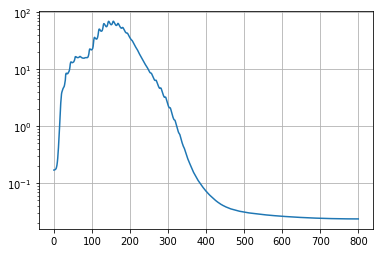

In [11]:
# ifstart and ifend can be determined from the figure below.
plt.yscale("log")
plt.plot(energy)
plt.grid()

In [12]:
ns, nr = pdown_f[0].shape
nk = nr//4

In [13]:
ns, nr

(200, 401)

In [14]:
ret = []

gradlist=[gradQQt]
proxlist=[prox_Fro]
inc = [2.0]

class args:
    lam = [0,]
    nit = 2000000
    inertia = 0
    verbose = False
    tol = 1e-5

ifstart, ifend = 0, 540


 

## The proposed MDD with $\lambda=0.1$

In [15]:
ret = []

args.lam = [0.1]

x0 = np.eye(nr, nk) +  np.eye(nr, nk)*1j

for idx in range(ifstart, ifend):
    
    ia = pdown_f[idx]
    ib = pup_f[idx]
        
    tau_guess = [norm(ia, 'fro')**2]
    x1 = ipalm(gradlist, proxlist, tau_guess, inc, diffQQt, args, ia, ib, [x0,])
    
    ret.append(x1[0])


In [16]:
ret = np.array(ret)
g1 = np.matmul(ret, ret.transpose(0,2,1))
g1 = np.fft.irfft(g1, n=nt, axis=0)

In [17]:
ret = []

args.lam = [.1]

x0 = np.zeros((nr, nr), dtype=np.complex64)

def diffAX(xs, ia, ib):
    xs = xs[0]
    xs = xs+xs.T
    xs *= 0.5
    r = ia.dot(xs) - ib
    return r

def gradAX(xs, ir, ia):
    
    AhR = ia.T.conj().dot(ir)
    
    dd = (AhR +  AhR.T)*0.5   

    return dd

gradlist=[gradAX]

for idx in range(ifstart, ifend):

    ia = pdown_f[idx]
    ib = pup_f[idx]
        
    tau_guess = [norm(ia, 'fro')**2]
    x1 = ipalm(gradlist, proxlist, tau_guess, inc, diffAX, args, ia, ib, [x0,])
    
    ret.append(x1[0])

In [18]:
ret = np.array(ret)
g0 = ret + ret.transpose(0,2,1)
g0 = np.fft.irfft(g0*0.5, n=nt, axis=0)

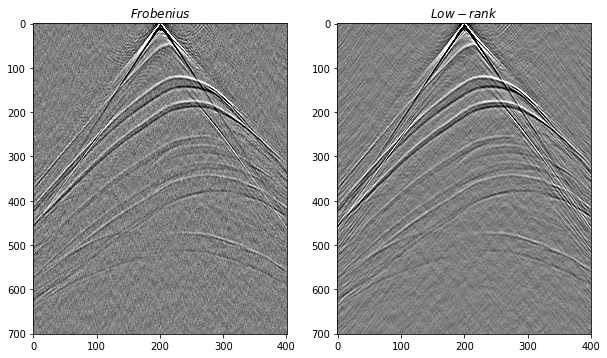

In [19]:
fig, axs = plt.subplots(1,2, figsize=(10,8))
pclip = 0.03

dat = g0[:701, 201] 
cc = np.abs(dat).max()
axs[0].imshow(dat, aspect=0.7, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
title = '$Frobenius$'
axs[0].set_title(title)



dat = g1[:701, 201] 
cc = np.abs(dat).max()
axs[1].imshow(dat, aspect=0.7, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
title = '$Low-rank$'
axs[1].set_title(title)

